# WDSS Football Forecasting Competition





<img src="logo_subtitle.png" width=500 height=500 />

## Our Sponsor

<img src="mustard-systems-logo.png" width=500 height=500 />

## The Competition

- Predicting the scores of football matches isn't a new idea 


- People try their luck at bookies daily with nothing more than guesses, however, at WDSS a more data-driven approach is preferred 

- The competition aims to draw together the best implementations of these with hopes of finding the best model possible 

## The Format

- Weekly predictions on the **scores** of each Premier League match


- Each week the predictions must be **ranked** from 1 to 10 in terms of confidence

- Each contestor's predictions will be scored based on their weighted **mean squared error** and converted into points using a monotonously-decreasing rule 

## The Rules

- All weekly submissions must be accompanied by a model created in Python Jupyter Notebook (.ipynb file) or R Markdown notebooks (.Rmd) 

- Scores predicted must match the output of your model (we will check this and disqualify inconsistent submissions) 



- There will be some flexibility in what constitutes as a model, but please refer to our demo model as a benchmark 



- Have Fun! 

## The Winner & Prize

- The competition will be split across Term 1 & 2 with a prize pool of £700 for each iteration 


- This prize pool will be split between the top competitors as ranked by the accuracy of their predictions 


- Additionally, a £100 prize will be awarded for the model that displays the most ingenuity, creativity, and good statistical practice 

# Getting Started: lets build a demo model

- Today we will guide you in building a baseline model for our upcoming Premier League forecasting competition 

- This model will NOT win the competition for you, but it will help point you in the right direction

## Start out with our imports

In [1]:
# Dependencies
from scipy.stats import poisson, skellam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Gathering our data

In [2]:
#### FUNCTION TO RETRIEVE PREMIER LEAGUE DATA ####
def get_premier_league_data(start_year):
    season = str(start_year)[-2:] + str(start_year + 1)[-2:]
    data = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + season + "/E0.csv") 
    return data

In [3]:
# Get data from the 2018/2019 season
data = get_premier_league_data(2018)
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


## Light cleaning

In [4]:
# Filtering columns of interest
columns = ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]
data = data[columns]

# Renaming columns
data = data.rename(
    columns={"FTHG": "HomeGoals", "FTAG": "AwayGoals", "FTR": "Result"}
)

In [5]:
# Remove final week of fixtures
data = data[:-10]

## Simple analysis: Home team advantage?


In [6]:
# Compute the average number of home and away goals
data[["HomeGoals", "AwayGoals"]].mean()

HomeGoals    1.575676
AwayGoals    1.224324
dtype: float64

## Towards a match prediction model 

- One way to predict the match score is to consider the number of goals scored by each team


- We will denote the number of goals scored by a particular team in a match by $y_i$, where $i$ indicates the particular match


- Furthermore, we will use *regression analysis* to model $\mathbb{E}[y_i | X_i]$ 

## The Poisson distribution

- The Poisson distribution is often used to model the probability distribution of *count events* (that is, the same event happening a specific number of times in a fixed time frame)


- It is a *discrete* distribution parametarized by a mean constant rate of occurences $\lambda$

- It assumes that event occurances within the interval are *independent* of one another

- It can be especially useful to model the number of goals we expect a team to score

## The Poisson distribution: an example

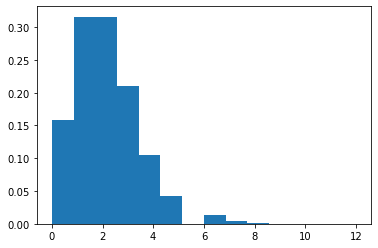

In [7]:
# Here we simulate 1 million samples from a Poisson distribution with a mean of two
x = np.random.poisson(2, 1000000)
plt.hist(x, 14, density=True)
plt.show()

## Formatting our data

In [8]:
#### PREPARE THE DATASET ####

# Separate home goals data
home_goals = data[["HomeTeam", "AwayTeam", "HomeGoals"]]
home_goals = home_goals.assign(home=1)
home_goals = home_goals.rename(
    columns={"HomeTeam": "team",
             "AwayTeam": "opponent", 
             "HomeGoals": "goals"}
)

# Separate away goals data
away_goals = data[["AwayTeam", "HomeTeam", "AwayGoals"]]
away_goals = away_goals.assign(home=0)
away_goals = away_goals.rename(
    columns={"AwayTeam": "team",
             "HomeTeam": "opponent", "AwayGoals": "goals"}
)

In [9]:
training_data = pd.concat([home_goals, away_goals])
training_data.head()

,team,opponent,goals,home
0,Man United,Leicester,2,1
1,Bournemouth,Cardiff,2,1
2,Fulham,Crystal Palace,0,1
3,Huddersfield,Chelsea,0,1
4,Newcastle,Tottenham,1,1


## The Poisson regression model

- To predict the number of goals each team scores, we will fit the following model using match-level data


$$y_i \sim Poisson(\lambda_i)$$


$$\ln (\lambda_i) = X_i\beta$$

- Here, $\lambda_i$ is the mean number goals scored by the home team in match $i$, which we aim to predict using variables $X_i$

In [10]:
# Building the model
# Poisson Regression: log-linear model
poisson_model = smf.glm(
    formula="goals ~ home + team + opponent",
    data=training_data,
    family=sm.families.Poisson() 
).fit()

In [11]:
# Get a statistical summary of the poisson model
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1030.1
Date:                Thu, 30 Sep 2021   Deviance:                       732.30
Time:                        00:34:01   Pearson chi2:                     634.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.4925      0.192      2.572      0.010       0.117       0.868
team[T.Bournemouth]           -0.2703      0.183     -1.481      0.139      -0.628       0.087
team[T.Brighton]              -0.7334      0.209     -3.503      0.000      -1.144      -0.323
team[T.Burnley]               -0.4493      0.192     -2.334      0.020      -0.827      -0.072
team[T.Cardiff]               -0.7702      0.214     -3.603      0.000      -1.189      -0.351
team[T.Chelsea]               -0.1249      0.174     -0.718      0.473      -0.466       0.216
team[T.Crystal Palace]        -0.4125      0.190     -2.169      0.030      -0.785      -0.040
team[T.Everton]               -0.3165      0.183     -1.726      0.084      -0.676       0.043
team[T.Fulham]                -0.6986      0.209     -3.335      0.001      -1.109      -0.288
team[T.Huddersfield]          -1.1820      0.249     -4.744      0.000      -1.670      -0.694
team[T.Leicester]             -0.3261      0.184     -1.768      0.077      -0.688       0.035
team[T.Liverpool]              0.1849      0.161      1.149      0.251      -0.130       0.500
team[T.Man City]               0.2291      0.159      1.438      0.150      -0.083       0.541
team[T.Man United]            -0.0621      0.173     -0.360      0.719      -0.401       0.276
team[T.Newcastle]             -0.6104      0.202     -3.024      0.002      -1.006      -0.215
team[T.Southampton]           -0.4387      0.193     -2.275      0.023      -0.817      -0.061
team[T.Tottenham]             -0.0917      0.173     -0.531      0.595      -0.430       0.247
team[T.Watford]               -0.3106      0.185     -1.683      0.092      -0.672       0.051
team[T.West Ham]              -0.3788      0.188     -2.017      0.044      -0.747      -0.011
team[T.Wolves]                -0.4239      0.189     -2.244      0.025      -0.794      -0.054
opponent[T.Bournemouth]        0.2458      0.189      1.303      0.192      -0.124       0.615
opponent[T.Brighton]           0.0890      0.195      0.456      0.648      -0.293       0.471
opponent[T.Burnley]            0.2413      0.188      1.282      0.200      -0.128       0.610
opponent[T.Cardiff]            0.2950      0.186      1.585      0.113      -0.070       0.660
opponent[T.Chelsea]           -0.2537      0.214     -1.185      0.236      -0.673       0.166
opponent[T.Crystal Palace]    -0.0269      0.200     -0.134      0.893      -0.420       0.366
opponent[T.Everton]           -0.1366      0.207     -0.659      0.510      -0.543       0.269
opponent[T.Fulham]             0.3861      0.182      2.121      0.034       0.029       0.743
opponent[T.Huddersfield]       0.3551      0.183      1.941      0.052      -0.003       0.714
opponent[T.Leicester]         -0.0595      

## A note on dummies, coefficients, and interpretation

## Forecasting the expected goals for each team

In [25]:
def predict_avg_goals(home_team, away_team, model):
    # Create feature data for home and away team for the match
    X_home = pd.DataFrame(data={"team": home_team,
                                "opponent": away_team,
                                "home": 1
                                }, index=[1])
    
    # Creating DataFrame for away team features
    X_away = pd.DataFrame(data={"team": away_team,
                                "opponent": home_team,
                                "home": 0
                                }, index=[1])
    
    # Predict the mean number of goals for home team
    home_goals_avg = model.predict(X_home).values[0]
    
    # Predict the mean number of goals for away team
    away_goals_avg = model.predict(X_away).values[0]
    
    return home_goals_avg, away_goals_avg

In [27]:
expected_goals = predict_avg_goals('Chelsea', 'Man City', poisson_model)
print('Expected Home Goals: ', expected_goals[0] )
print('Expected Away Goals: ', expected_goals[1])

Expected Home Goals:  0.8286416403375738
Expected Away Goals:  1.596649000341837


## Forecasting the distribution of match scores

In [20]:
#### MATCH SCORE FORECASTING FUNCTION ####
def predict_match_pmf(X_home, X_away, model, max_goals):
    # Predict the mean number of goals for home team
    home_goals_avg = model.predict(X_home).values[0]
    
    # Predict the mean number of goals for away team
    away_goals_avg = model.predict(X_away).values[0]
    
    # Compute marginal distribution for home goals
    home_goals_pmf = [poisson.pmf(i, home_goals_avg) 
                      for i in range(0, max_goals + 1)]
    
    # Compute marginal distribution for away goals
    away_goals_pmf = [poisson.pmf(i, away_goals_avg) 
                      for i in range(0, max_goals + 1)] 
    
    # Compute joint distribution for match score as outer product
    joint_pmf = np.outer(np.array(home_goals_pmf), 
                         np.array(away_goals_pmf))

    home_goals_pred = np.argmax(joint_pmf) // (max_goals + 1)
    away_goals_pred = np.argmax(joint_pmf) % (max_goals + 1)

    return (home_goals_pred, away_goals_pred)

In [21]:
predict_match("Chelsea", "Man City", max_goals=7, model=poisson_model)

(0, 1)

In [ ]:
# Simulate matches for any given PL seaason
# Takes in dataset as input


def simulate_test(x):
    
    """
    SIMLUTAING MODEL
    Y_HAT VS Y_TRUE
    """

    data = x.copy()

    data["HomePred"] = [0] * len(data)
    data["AwayPred"] = [0] * len(data)

    for i in range(len(data)):
        homeTeam = data["HomeTeam"][i]
        awayTeam = data["AwayTeam"][i]

        simulate_match_clean(homeTeam, awayTeam)
        data.loc[i, "HomePred"] = int(h)
        data.loc[i, "AwayPred"] = int(a)

    data = pd.DataFrame.from_dict(data)

    return data


data_post = simulate_test(data)
data_post

In [ ]:
# Add prediction results column
# NOT WORKING - Does not register draws


def update_df_res(data):
    """
    function to obtain results... broken.
    """

    ResultPred = []

    for i in data["HomePred"]:
        if i == data["AwayPred"][i]:
            ResultPred.append("D")
        elif i < data["AwayPred"][i]:
            ResultPred.append("A")
        else:
            ResultPred.append("H")

    data = pd.concat([data, pd.Series(ResultPred)], axis=1).rename(
        {0: "ResultPred"}, axis=1
    )

    return data

In [ ]:
# Validate full time result prediction


def update_df_ftr(data):
    
    """
    appends true or false deppending on whether resut matches
    """

    correctFTR = []

    for i in range(len(data)):
        if str(data["ResultPred"][i]) is str(data["Result"][i]):
            correctFTR.append(True)
        else:
            correctFTR.append(False)

    data = pd.concat([data, pd.Series(correctFTR)], axis=1).rename(
        {0: "correctFTR"}, axis=1
    )

    return data

In [ ]:
# Vallidate Scoreline Prediction


def update_df_correct(data):
    """
    TRUE, FALSE, HOME, AWAY
    """

    correctScore = []

    for i in range(len(data)):
        if (
            data["HomeGoals"][i] == data["HomePred"][i]
            and data["AwayGoals"][i] == data["AwayPred"][i]
        ):
            correctScore.append(True)
        elif data["HomeGoals"][i] == data["HomePred"][i]:
            correctScore.append("Home")
        elif data["AwayGoals"][i] == data["AwayPred"][i]:
            correctScore.append("Away")
        else:
            correctScore.append(False)

    data = pd.concat([data, pd.Series(correctScore)], axis=1).rename(
        {0: "correctScore"}, axis=1
    )

    return data

In [ ]:
# Add validation columns
# NOT WORKING - Does not take into account draws


def update_df(data):
    
    """
    COMBO OF THREE ABOVE
    """

    ResultPred = []

    for i in data["HomePred"]:
        if int(i) > int(data["AwayPred"][i]):
            ResultPred.append("H")
        elif int(i) == int(data["AwayPred"][i]):
            ResultPred.append("D")
        else:
            ResultPred.append("A")

    data = pd.concat([data, pd.Series(ResultPred)], axis=1).rename(
        {0: "ResultPred"}, axis=1
    )

    correctFTR = []

    for i in range(len(data)):
        if str(data["ResultPred"][i]) is str(data["Result"][i]):
            correctFTR.append(True)
        else:
            correctFTR.append(False)

    data = pd.concat([data, pd.Series(correctFTR)], axis=1).rename(
        {0: "correctFTR"}, axis=1
    )

    correctScore = []

    for i in range(len(data)):
        if (
            data["HomeGoals"][i] == data["HomePred"][i]
            and data["AwayGoals"][i] == data["AwayPred"][i]
        ):
            correctScore.append(True)
        elif data["HomeGoals"][i] == data["HomePred"][i]:
            correctScore.append("Home")
        elif data["AwayGoals"][i] == data["AwayPred"][i]:
            correctScore.append("Away")
        else:
            correctScore.append(False)

    data = pd.concat([data, pd.Series(correctScore)], axis=1).rename(
        {0: "correctScore"}, axis=1
    )

    return data


# epl_1819_post = update_df(epl_1819_post)

In [ ]:
# At least one correct prediction (home, away or both)
sum(epl_1819_post["correctScore"].value_counts()[-3:])

## Visualizing our model performance

In [ ]:
chelsea_mancity = simulate_match("Chelsea", "Man City")

In [ ]:
def goal_matrix(homeTeam, awayTeam):

    x = simulate_match(homeTeam, awayTeam)

    # *Match the plotting functions to the max goals
    # Axes labels
    goals = [0, 1, 2, 3, 4, 5, 6, 7, 8]

    # Plot figure
    fig, ax = plt.subplots(figsize=(3, 3), dpi=400)
    fig.tight_layout()
    im = ax.imshow(x, cmap="winter")

    # Add grid
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis="both", which="minor", color="w", length=0)
    ax.grid(which="minor", color="b", linestyle="-", linewidth=0.6)

    # Set ticks and paremeters
    ax.set_yticks(np.arange(len(goals)))
    ax.set_yticklabels(goals, fontsize=5)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(goals)))
    ax.set_xticklabels(goals, fontsize=5)

    ax.tick_params(axis="both", which="major", length=2, pad=1.5)

    ax.set_ylabel("Home Goals", fontsize=6)  # axes label (y)
    ax.set_xlabel("Away Goals", fontsize=6)
    ax.xaxis.set_label_position("top")

    # * Set this to the Home vs Away teams
    ax.set_title("Chelsea vs Sunderland Forecast", fontsize=7, y=1.1)
    ax.set_title(
        str(homeTeam) + " vs. " + str(awayTeam) + " Forecast", fontsize=7, y=1.1
    )

    # *rename this variable
    # Rounding probabilites to add to the plot
    rounded = x.tolist()
    rounded3 = []
    for z in rounded:
        rounded2 = [round(x, 3) for x in z]
        rounded3.append(rounded2)
    rounded3 = np.array(rounded3)

    for i in range(len(goals)):
        for j in range(len(goals)):
            text = ax.text(
                j,
                i,
                rounded3[i, j],
                ha="center",
                va="center",
                color="black",
                fontsize=3,
                fontfamily="monospace",
            )

    plt.show()


goal_matrix("Man City", "Burnley")

In [ ]:
# Define a function to get the seasons fixtures from csv
def get_epl_fixtures(season):
    """
    Takes in season formatted as YYYY (First Year of the season)
    """
    # x = pd.read_csv("https://fixturedownload.com/download/csv/epl-" + str(season)) # input season year within hyperlink
    x = pd.read_csv(
        "https://fixturedownload.com/download/epl-"
        + str(season)
        + "-GMTStandardTime.csv"
    )  # input season year within hyperlink

    x = x[
        ["Round Number", "Home Team", "Away Team", "Result", "Date"]
    ]  # isolate required columns
    x = x.rename(
        columns={"Round Number": "GW", "Home Team": "HomeTeam", "Away Team": "AwayTeam"}
    )
    globals()["epl_fixtures_" + str(season)] = x

    return globals()["epl_fixtures_" + str(season)]

In [ ]:
get_epl_fixtures(2021)

In [ ]:
# Get this weeks fixtures
epl_fixtures_2021[50:60][:]

#### Season Standings

https://www.rotowire.com//soccer/tables/standings.php?league=EPL&length=total&season=2019

https://www.rotowire.com/soccer/league-table.php?season=2018

### Next Steps

- Build on the baseline.
- Dixon Coles model
- Betting odds as regressors
- Participate in the competition.